## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os
from itertools import compress

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
from tensorflow.python import debug as tf_debug
print("Tensorflow version:", tf.__version__)

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate
from embodied_arch.embodied_central_Qcritic import QsaNetwork

In [3]:
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
importlib.reload(MGME) 


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'

## Setup k-vs-(N-k) Mingame Env

In [4]:
importlib.reload(MGME)

# n_agents = 61
# exos = (np.random.sample(n_agents) < 0.3)  # np.sum(exos)
# exos = [True, True, False, False, False, True]  # Majority subpop
# exos = [True, True, False, False, False, False]  # Minority subpop

exos = [True, True, True, False, False, False, False, False, False, False]  # Minority subpop
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

10 3 [0, 1, 2]
3 1


## Setup MARL

In [5]:
# num_episodes, n_epochs, max_len = (100, 601, 251)
# num_episodes, n_epochs, max_len = (100, 751, 150)
num_episodes, max_len, n_epochs, evry = (100, 100, 601, 150)

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=5e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(
    st, hSeq=(16,16,), 
    out_dim=out_dim, gamma_reg=5.
)

qsa = lambda sts, ats: QsaNetwork(
    sts, ats, 
    hSeq=(16,8,), gamma_reg=1.5
)

In [7]:
tf.reset_default_graph()
importlib.reload(emac)
emac._ent_decay_ = 0.5
print(emac._ent_decay_)

0.5


In [8]:
empopn = emac.EmbodiedAgent_MAC(
    name="mgMAC_k-vs-N-k", env_=menv, 
    alpha_p=20., alpha_v=10., alpha_q=5.,
    actorNN=actor, valueNN=value,
    latentDim=12, sensorium=sensor, QNN=qsa,
    max_episode_length=max_len, _every_=evry,
    CyclicSchedule=None #("log", 150)  #("exp", 150)
)

In [9]:
sess = tf.InteractiveSession()
empopn.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgMAC_k-vs-N-k


In [10]:
## Verify step + play set up
state = empopn.env.reset() 
empopn.play(sess)
np.sum(np.array(empopn.episode_buffer['rewards']), axis=0)
# np.array(empopn.episode_buffer['rewards'])

array([20., 47., 31.])

### Burn-in Minority Game to Equilibrium

[[0 0 0]
 [0 0 0]
 [0 0 0]]
[0. 0. 0.] 0.0 0.0


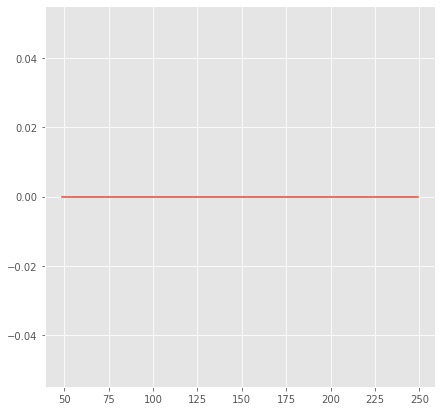

In [11]:
burn_in = 250  # n_epochs
print(empopn.env.reset())

mg_hist = np.zeros([burn_in, sum(exos)])
for k in range(burn_in):
    tmp = np.zeros(sum(exos))
    for _ in range(empopn.max_episode_length): 
        _, popn_acts, _ = empopn.env.stepAll()
        tmp += 100.*np.array(
            list(compress(popn_acts, exos)), dtype=float)/float(empopn.max_episode_length)
    mg_hist[k,:] = tmp

# rwd_hist = 100.*mg_hist/float(empopn.max_episode_length)
rwd_hist = mg_hist
plt.plot(pd.Series(np.mean(mg_hist, axis=1)).rolling(window=50).mean().values);

print(
    np.mean(mg_hist, axis=0),
    np.mean(np.mean(mg_hist, axis=1)[:empopn.max_episode_length]),
    np.mean(np.mean(mg_hist, axis=1)[-empopn.max_episode_length:])
)


# no equilibrium, just cycling

### Baseline for Agents

In [12]:
print('Baselining untrained pnet...')
rwd_mg0 = []
acts_cov = np.zeros([empopn.actor_count,empopn.actor_count])
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg0.append(empopn.last_total_returns)
    actions = np.array(empopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
base_perf_mg = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwd_mg0)/float(empopn.max_episode_length), axis=0)

print("\nAgents win an average of {} pct".format(base_perf_mg))
print("\nPer Agent Win Pct: {} pct".format(base_per_agent))

Baselining untrained pnet...
Episode 99/100
Agents win an average of 32.019999999999996 pct

Per Agent Win Pct: [22.89 40.14 33.03] pct


Agent Action Correlations:


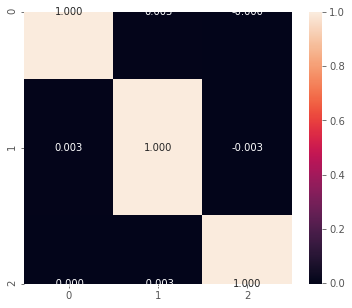

In [13]:
plt.rcParams['figure.figsize'] = (6,5)
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Agent Action Correlations:")
sns.heatmap(acts_corr, annot=True, fmt="0.3f")

## Train MARL Agents

	 Iteration 124: Q loss([4.7583165 7.0082097 6.409346 ]))2])

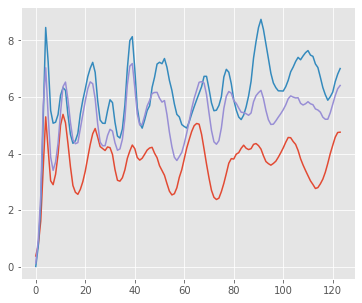

In [14]:
obs = []
for ct in range(125):
    empopn.play(sess)
    tmp = empopn.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    print('\r\t Iteration {}: Q loss({})'.format(ct, np.mean(tmp, axis=0)), end="")
plt.plot(obs[1:]);

In [15]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = empopn.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent mgMAC_k-vs-N-k
Epoch no.: 0/601

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (24.0, 32.666666666666664, 40.0)
Losses/Policy LLs: (-1.8331025, -0.63287497, -0.1675408)
Losses/Policy Entropies: (0.43002427, 0.5508197, 0.66985285)
Values/Critic Scores: (-0.3262941, 0.82861656, 1.6084105)
Values/Mean Q Scores: (5.4208946, 7.010306, 8.127873)
Saved Model
Epoch no.: 150/601

	Stats @Step 150: 	(Min, Mean, Max)
Perf/Recent Rewards: (15.0, 16.0, 17.0)
Losses/Policy LLs: (-3.7440424, -0.079772785, -3.0719475e-05)
Losses/Policy Entropies: (0.01, 0.11264686, 0.57933944)
Values/Critic Scores: (-0.7754621, 1.7437931, 3.8083096)
Values/Mean Q Scores: (5.843643, 7.6659913, 8.666608)
Saved Model
Epoch no.: 300/601

	Stats @Step 300: 	(Min, Mean, Max)
Perf/Recent Rewards: (46.0, 48.0, 49.0)
Losses/Policy LLs: (-3.8511064, -0.07223044, -3.1236697e-05)
Losses/Policy Entropies: (0.01, 0.044207346, 0.10288859)
Values/Critic Scores: (-1.0370986, 2.0123713, 3.9241886)
Va

### Post-test Agent

In [16]:
# Test pnet!
print('Testing...')
rwd_mg = []
acts_cov = np.zeros([empopn.actor_count,empopn.actor_count])
for k in range(num_episodes):
    empopn.play(sess, terminal_reward=0.)
    rwd_mg.append(empopn.last_total_returns)
    actions = np.array(empopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
trained_perf_mg = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwd_mg)/float(empopn.max_episode_length), axis=0)

Testing...
Episode 99/100

In [17]:
print("\nAgent wins an average of {:0.3f} pct compared to baseline of {:0.3f} pct".format(
    trained_perf_mg, base_perf_mg) )

print("\nBaseline Per Agent Win Pct: {} pct".format(base_per_agent))
print("Trained Per Agent Win Pct: {} pct".format(trained_per_agent))


Agent wins an average of 49.777 pct compared to baseline of 32.020 pct

Baseline Per Agent Win Pct: [22.89 40.14 33.03] pct
Trained Per Agent Win Pct: [49.45 50.43 49.45] pct


In [ ]:
plt.rcParams['figure.figsize'] = (6,5)
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom


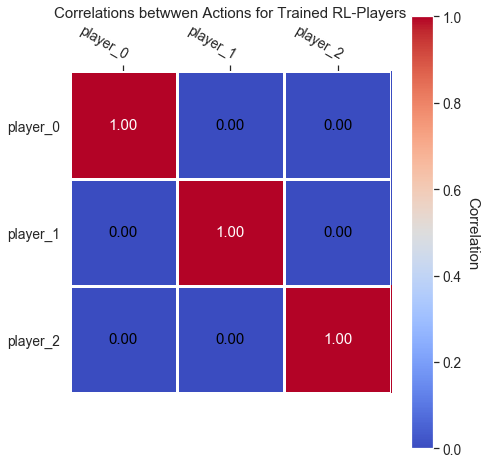

In [55]:
import misc_expts

plt.rcParams['figure.figsize'] = (7, 7)
fig, ax = plt.subplots()
ax.grid(False)
ax.set_title("Correlations betwwen Actions for Trained RL-Players")
im, cbar = heatmap(data=(acts_corr), 
                   row_labels=empopn.actor_names, col_labels=empopn.actor_names, 
                   ax=ax, cmap="coolwarm", cbarlabel="Correlation") #cmap="coolwarm" RdYlGn
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [19]:
rwds0_df = pd.DataFrame(100.*(np.array(rwd_mg0)/float(empopn.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwd_mg)/float(empopn.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
# print(resDF.shape)
# resDF.head()

resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Win_pct"})
# print(resDF.shape)
res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs
# resDF.head()

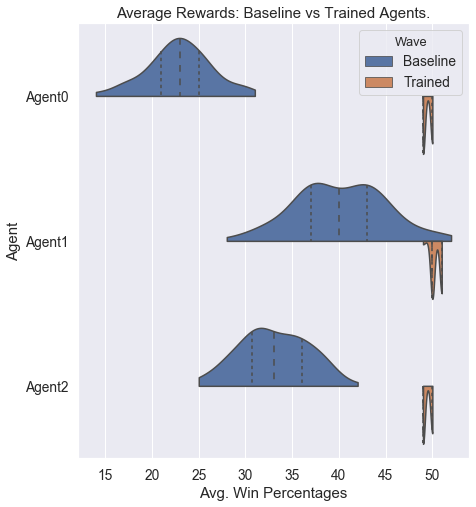

In [20]:
plt.rcParams['figure.figsize'] = (7, 8)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, x="Win_pct", y="Agent",
                     cut=0, hue="Wave",
                     split=True, scale="count", inner="quartile");
fig.set_title(
    'Average Rewards: Baseline vs Trained Agents.');
fig.set_xlabel('Avg. Win Percentages');
# fig.legend(loc='upper left');

In [21]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Win_pct_Change']
# mean_diffDF.head()

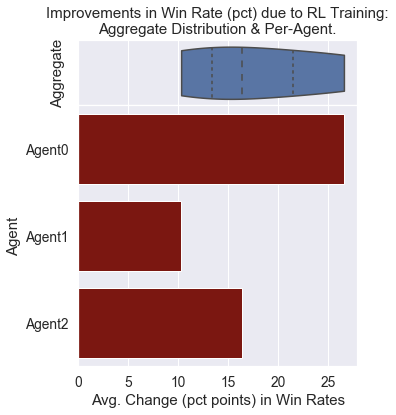

In [52]:
plt.rcParams['figure.figsize'] = (5, 6)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Win_pct_Change', cut=0, inner='quartile',data=mean_diffDF, ax=axs[0])
# cmp = sns.boxplot(x='Mean_Win_pct_Change',data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Aggregate');
axs[0].set_title(
    'Improvements in Win Rate (pct) due to RL Training:\nAggregate Distribution & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Win_pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change (pct points) in Win Rates');

### Baseline for Default Behavioral Model

In [23]:
mg_hist = np.zeros([num_episodes, sum(exos)])
for k in range(num_episodes):
    tmp = np.zeros(sum(exos))
    for _ in range(empopn.max_episode_length):
        _, popn_acts, _ = empopn.env.stepAll()
        tmp += 100.*np.array(
            list(compress(popn_acts, exos)), dtype=float)/float(empopn.max_episode_length)
    mg_hist[k,:] = tmp

np.mean(mg_hist, axis=0)

array([0.02, 0.01, 0.02])

In [24]:
rwds_dbm = mg_hist # 100.*mg_hist/float(empopn.max_episode_length)

print(np.mean(rwds_dbm), "\n",
      np.mean(rwds_dbm, axis=0)
     )

0.016666666666666666 
 [0.02 0.01 0.02]


### Compare to Default Behavioral Model

[49.43 50.42 49.43]


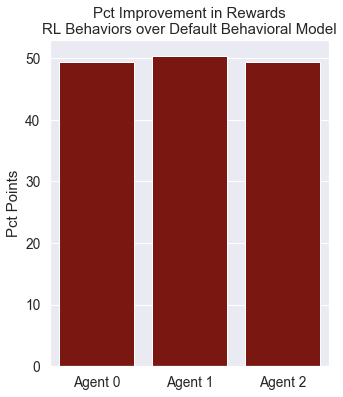

In [53]:
trcmp = 100.*(np.array(rwd_mg)/float(empopn.max_episode_length))
cmp = np.mean((trcmp-rwds_dbm), axis=0)
print(cmp)
bplot = sns.barplot(x=["Agent "+str(j) for j in range(sum(exos))], y=cmp, color="r");
bplot.set_ylabel('Pct Points');
bplot.set_title(
    'Pct Improvement in Rewards\nRL Behaviors over Default Behavioral Model');

In [26]:
plt.rcParams['figure.figsize'] = (8,3)
np.mean(trcmp - np.mean(rwds_dbm, axis=0))

49.76